# Decision Tree Classifier

## Libraries and Functions

In [1]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from DecisionTreeClassifier import DecisionTreeClassifier as DTC

A function to create datasets.

In [2]:
def mixGauss(means, sigmas, n):

    means = np.array(means)
    sigmas = np.array(sigmas)

    d = means.shape[1]
    num_classes = sigmas.size
    data = np.full((n * num_classes, d), np.inf)
    labels = np.zeros(n * num_classes)

    for idx, sigma in enumerate(sigmas):
        data[idx * n:(idx + 1) * n] = np.random.multivariate_normal(mean=means[idx], cov=np.eye(d) * sigmas[idx] ** 2,
                                                                    size=n)
        labels[idx * n:(idx + 1) * n] = idx 
        
    if(num_classes == 2):
        labels[labels==0] = -1

    return data, labels

A function to find the best height parameter using cross-validation procedure.

In [3]:
def bestHeight_KFoldCV(Xtr, Ytr, attributes_list, classes, criterion, KF, height_list):

    if KF <= 0:
        print("Please supply a positive number of repetitions")
        return -1

    # ensures that k_list is a numpy array
    height_list = np.array(height_list)
    num_heights = height_list.size

    n_tot = Xtr.shape[0]
    n_val = int(np.ceil(n_tot/KF))

    Tm = np.zeros(num_heights)
    Ts = np.zeros(num_heights)
    Vm = np.zeros(num_heights)
    Vs = np.zeros(num_heights)

    # random permutation of training data
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    
    for kdx, height in enumerate(height_list):
        first = 0
        for fold in range(KF):
            flags = np.zeros(Xtr.shape[0])
            flags[first:first+n_val]=1;
            
            X = Xtr[rand_idx[flags==0]]
            Y = Ytr[rand_idx[flags==0]]
            X_val = Xtr[rand_idx[flags==1]]
            Y_val = Ytr[rand_idx[flags==1]]

            # compute the training error for the given value of height
            Dt = DTC(height, (X,Y), attributes_list, criterion)
            Dt.train()
            
            trError = Dt.test(X,Y)[2]
            Tm[kdx] = Tm[kdx] + trError
            Ts[kdx] = Ts[kdx] + trError ** 2

            # compute the validation error for the given value of height
            valError = Dt.test(X_val,Y_val)[2]
            Vm[kdx] = Vm[kdx] + valError
            Vs[kdx] = Vs[kdx] + valError ** 2
            
            first = first+n_val                

    Tm = Tm / KF
    Ts = Ts / KF - Tm ** 2

    Vm = Vm / KF
    Vs = Vs / KF - Vm ** 2

    best_height_idx = np.argmin(Vm)
    best_height = height_list[best_height_idx]

    return [best_height], Vm, Vs, Tm, Ts

A function to visualize the separating function.

In [4]:
def separatingFLR(Xtr, Ytr, Ypred):
    xi = np.linspace(Xtr[:, 0].min(), Xtr[:, 0].max(), 200)
    yi = np.linspace(Xtr[:, 1].min(), Xtr[:, 1].max(), 200)
    X, Y = np.meshgrid(xi,yi)
    
    zi = griddata(Xtr, Ypred, (X,Y), method='linear')
    
    plt.contour(xi, yi, zi, 15, linewidths=2, colors='k', levels=[0])
    # plot data points.
    plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr, marker='o', s=100, zorder=10, alpha=0.8)
    plt.xlim(Xtr[:,0].min(), Xtr[:,0].max())
    plt.ylim(Xtr[:,1].min(), Xtr[:,1].max())

A function to add some noise to the labels.

In [5]:
def flipLabels(Y, perc):
    if perc < 1 or perc > 100:
        print("p should be a percentage value between 0 and 100.")
        return -1

    if any(np.abs(Y) != 1):
        print("The values of Ytr should be +1 or -1.")
        return -1

    Y_noisy = np.copy(np.squeeze(Y))
    if Y_noisy.ndim > 1:
        print("Please supply a label array with only one dimension")
        return -1

    n = Y_noisy.size
    n_flips = int(np.floor(n * perc / 100))
    idx_to_flip = np.random.choice(n, size=n_flips, replace=False)
    Y_noisy[idx_to_flip] = -Y_noisy[idx_to_flip]

    return Y_noisy

A function to plot errors given a list of heights.

In [6]:
def plotErrorBestDepthMethod(Vm, Vs, Tm, Ts, height_list):
    fig = plt.figure(figsize=(10,8)) 
    ax0 = fig.add_subplot(2, 2, 1)
    ax1 = fig.add_subplot(2, 2, 2)

    ax0.set_title('Mean Error')
    ax0.semilogx(height_list, Tm,'-o' , label='Training Error: MEAN')
    ax0.semilogx(height_list, Vm, '-o', label='Validation Error: MEAN')
    ax0.set_xlabel("Height")
    ax0.set_ylabel("Error")
    ax0.legend()
    ax0.grid()
    
    ax1.set_title('Variance Error')
    ax1.semilogx(height_list, Ts,'-o' , label='Training Error: VARIANCE')
    ax1.semilogx(height_list, Vs, '-o', label='Validation Error: VARIANCE')
    ax1.set_xlabel("Height")
    ax1.set_ylabel("Error")
    ax1.legend()
    ax1.grid()

A function to plot the decision surface.

In [7]:
def Area(DT, Xtr, Ytr, Xte, Yte, cm = plt.cm.RdBu, cm_bright = ListedColormap(['#FF0000', '#0000FF'])):
    xi = np.arange(Xtr[:, 0].min() - 0.5, Xtr[:, 0].max() + 0.5, 0.02 ) 
    yi = np.arange(Xtr[:, 1].min() - 0.5, Xtr[:, 1].max() + 0.5, 0.02 ) 
    X, Y = np.meshgrid(xi,yi)
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Xt_p, Y_pred = DT.prediction(np.c_[X.ravel(),Y.ravel()])
    Y_pred = Y_pred.reshape(X.shape)
    plt.contourf(X, Y, Y_pred, cmap=cm, alpha=.8)
    
    plt.scatter(Xtr[:, 0], Xtr[:, 1], c=Ytr, cmap=cm_bright, edgecolors='k', alpha = 0.5, label= 'Training set')
    plt.scatter(Xte[:, 0], Xte[:, 1], c=Yte, cmap=cm_bright, edgecolors='k', alpha = 1.0, label= 'Test set')
    plt.title("Decision surface")
    plt.xlim(X.min(), X.max())
    plt.ylim(Y.min(), Y.max())
    plt.tight_layout()

A function to split the dataset according to a given percentage.

In [8]:
def splitData(X, Y, P):
    
    labels = np.unique(Y).astype(int)
    first = 1
    
    for L in labels:
        
        ntr = int(np.ceil(len(Y[Y==L])*P))
        nte = len(Y[Y==L])-ntr
        
        idx = np.random.permutation(len(Y[Y==L]))
        Lidx = np.where(Y==L)[0]
        
        XL = X[Lidx,:]
        YL = Y[Y==L]
    
        X1 = XL[idx[:ntr],:]
        Y1 = YL[idx[:ntr]]
    
        X2 = XL[idx[ntr:],:]
        Y2 = YL[idx[ntr:]]
        
        if(first==1):
            Xtr = X1
            Ytr = Y1
            Xte = X2
            Yte = Y2
            first = 0
        else:
            Xtr = np.append(Xtr, X1, axis=0)
            Ytr = np.append(Ytr, Y1, axis=0)
            Xte = np.append(Xte, X2, axis=0)
            Yte = np.append(Yte, Y2, axis=0)
            
    return Xtr, Ytr, Xte, Yte

## Binary Classification Problem

Let's see how a decision tree works with a simple binary classification problem.

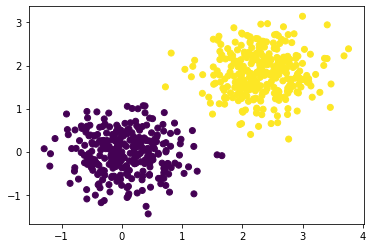

In [10]:
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of columns to be considered by the algorithm
Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 300) #training set
Xte, Yte = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) #test set
plt.scatter(Xtr[:,0], Xtr[:,1], c=Ytr)

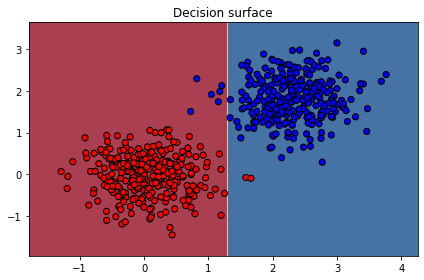

In [11]:
Dt = DTC(2, (Xtr,Ytr), attributes_list, DTC.ENTROPY) # we consider only the first split
Dt.train() 
Area(Dt, Xtr, Ytr, Xtr, Ytr) # training and test set are coincident in the plot

Considering only the first split, the decision tree divided the input space into two axis-parallel rectangles maximizing the purity as much as possible using x-axis. Rectangles represent partitions. The decision tree fixed a threshold which is used as a test in the following way: *data point<=threshold* belongs to red class, otherwise, it belongs to the blue one. The result is a plane divided into two partitions in which the left partition represents the red class, and the right partition represents the blue one.

Now we further split the dataset considering the first and the second split.

Training error:  0.0


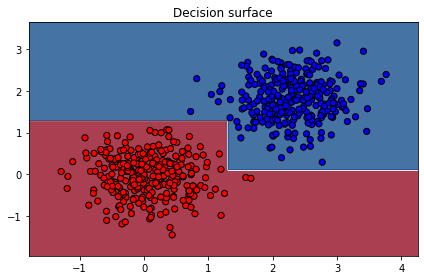

In [12]:
Dt = DTC(3, (Xtr,Ytr), attributes_list, DTC.ENTROPY) # we consider the first and the second split
Dt.train()
err_tr = Dt.test(Xtr, Ytr) [2]
print("Training error: ", err_tr)
Area(Dt, Xtr, Ytr, Xtr, Ytr) # training and test set are coincident in the plot

The training set is now split according to the y-axis and now it cannot be split anymore because all the data points in the resulting partitions are perfectly classified.

Test error:  0.005


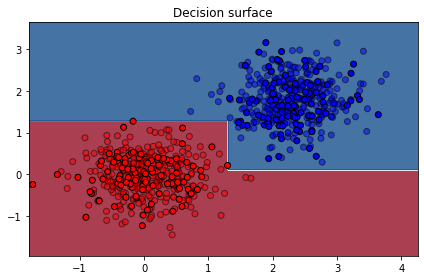

In [13]:
err_te = Dt.test(Xte, Yte) [2] 
print("Test error: ", err_te)
Area(Dt, Xtr, Ytr, Xte, Yte) #training and test set are coincident in the plot

We obtain a test error higher than the training error, so this model overfits.

### Training Set Size Effect

We want to analyze how the size of the training set affects the height of the tree.

Sizes:  [ 80 100 120 140 160 180 200 220 240 260 280 300]


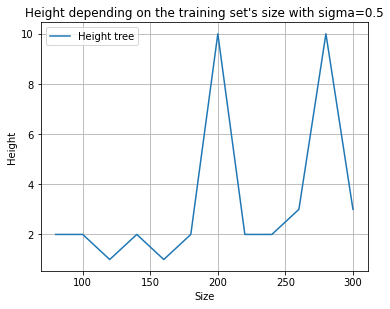

In [21]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
step = 20
size_list = np.arange(80, 300 + step , step)
print("Sizes: ", size_list)
height_list = np.zeros(size_list.size)

for idx, size in enumerate(size_list):
    
    Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], size) # training set
    Dt = DTC(float('+inf'), (Xtr,Ytr), attributes_list, DTC.GINI) 
    Dt.train() 
    height_list[idx] = Dt.getMaxDepth()
    
plt.subplot(2,2,1)
plt.plot(size_list, height_list, label= 'Height tree')
plt.title("Height depending on the training set's size with sigma=0.5")
plt.xlabel('Size')
plt.ylabel('Height')
plt.axis("tight")
plt.legend()
plt.grid()
plt.tight_layout()

Sizes:  [ 80 100 120 140 160 180 200 220 240 260 280 300]


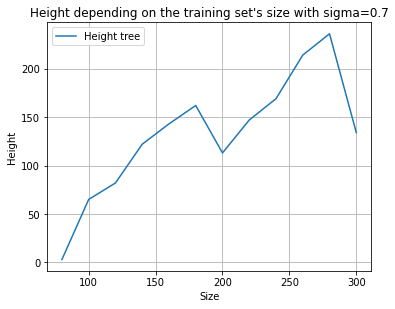

In [23]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
step = 20
size_list = np.arange(80, 300 + step , step)
print("Sizes: ", size_list)
height_list = np.zeros(size_list.size)

for idx, size in enumerate(size_list):
    
    Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.7, 0.7], size) # training set
    Dt = DTC(float('+inf'), (Xtr,Ytr), attributes_list, DTC.GINI) 
    Dt.train() 
    height_list[idx] = Dt.getMaxDepth()
    
plt.subplot(2,2,1)
plt.plot(size_list, height_list, label= 'Height tree')
plt.title("Height depending on the training set's size with sigma=0.7")
plt.xlabel('Size')
plt.ylabel('Height')
plt.axis("tight")
plt.legend()
plt.grid()
plt.tight_layout()

The height of the decision tree tends to increase as the training set size increases. The result is more evident and more "stable" using a *sigma=0.7*.

### Noise Effect

We want to analyze how the noise affects the height and the performances.

Noises:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50]


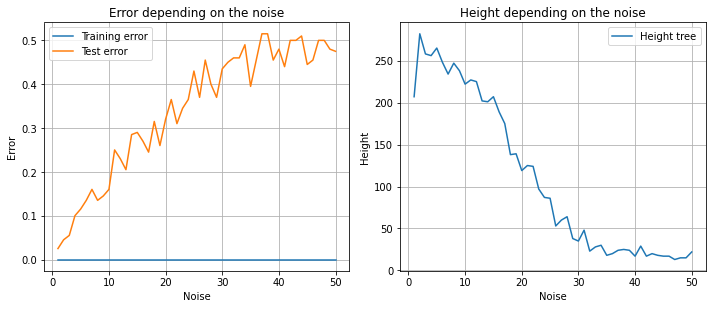

In [15]:
fig = plt.figure(figsize=(10,8))
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 300) # training set
Xte, Yte = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # test set
step = 1
noise_list = np.arange(1, 50 + step , step)
print("Noises: ", noise_list)
err_train = np.zeros(noise_list.size)
err_test = np.zeros(noise_list.size)
height_list = np.zeros(noise_list.size)

for idx, noise in enumerate(noise_list):
    
    Ytr_noised = flipLabels(Ytr, noise)
    Yte_noised = flipLabels(Yte, noise)

    Dt = DTC(float('+inf'), (Xtr,Ytr_noised), attributes_list, DTC.GINI) 
    Dt.train() 
    
    err_train[idx] = Dt.test(Xtr, Ytr_noised) [2]
    err_test[idx] = Dt.test(Xte, Yte_noised) [2]
    height_list[idx] = Dt.getMaxDepth()
    
plt.subplot(2,2,1)
plt.plot(noise_list, err_train, label= 'Training error')
plt.plot(noise_list, err_test, label= 'Test error')
plt.title("Error depending on the noise")
plt.xlabel('Noise')
plt.ylabel('Error')
plt.axis("tight")
plt.legend()
plt.grid()
plt.subplot(2,2,2)
plt.plot(noise_list, height_list, label= 'Height tree')
plt.title("Height depending on the noise")
plt.xlabel('Noise')
plt.ylabel('Height')
plt.axis("tight")
plt.legend()
plt.grid()
plt.tight_layout()

From these plots, we can observe:
* As the noise increases, the training error remains the same while the test error increases, so the model overfits.
* As the noise increases, the height of the tree decreases. If the training set is a little bit noised, then the algorithm has to split the data several times (using different tests) to find pure partitions which are composed of one point (the noised point) and that's why the height is greater at the beginning. Then, the height decreases because the algorithm, finding chunks of many points belonging to the same class (even if they are noised), doesn't need so many tests in order to get pure partitions.

### Limiting the Height

Wa want to analyze the performances if the height of the tree is limited.

Heights:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


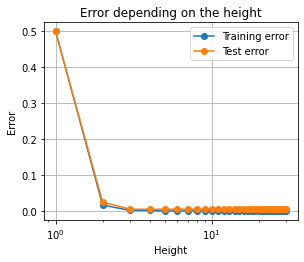

In [16]:
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 300) # training set
Xte, Yte = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # test set
step = 1
height_list = list(np.arange(1, 30 + step , step))
print("Heights: ", height_list)
err_train = np.zeros(np.size(height_list))
err_test = np.zeros(np.size(height_list))

for idx, height in enumerate(height_list):
    
    Dt = DTC(height, (Xtr,Ytr), attributes_list, DTC.GINI) # the height is limited using the first parameter
    Dt.train() 
    err_train[idx] = Dt.test(Xtr, Ytr) [2]
    err_test[idx] = Dt.test(Xte, Yte) [2]

fig = plt.figure(figsize=(10,8)) 
ax = fig.add_subplot(2, 2, 1)
ax.semilogx(height_list, err_train, '-o', label= 'Training error')
ax.semilogx(height_list, err_test, '-o', label= 'Test error')
ax.set_title("Error depending on the height")
ax.set_xlabel('Height')
ax.set_ylabel('Error')
ax.axis("tight")
plt.legend()
plt.grid()

From this plot, we can observe that both training and test error decrease with the increase of the height. In particular, from a certain point on, the training error is a little bit lower than the test error and they are both almost equal to zero, so the model overfits and this means that it doesn't capture mainly the most useful patterns. These results suggest that the height could be used as a hyper-parameter to avoid overfitting and underfitting.

### Pruning the Tree

Pruning is a good method to control overfitting. In this scenario, the decision tree is let to grow and then is pruned in the following way: the dataset is divided into two sets: test set and training set and the latter is further split into two sets so that the first one, characterized by *Xtr_train* and *Ytr_train*, is used to train the model and the second one, named pruning set, is used to prune the tree. We want to analyze how pruning affects the performances.

Sizes:  [0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7  0.75
 0.8  0.85 0.9  0.95]


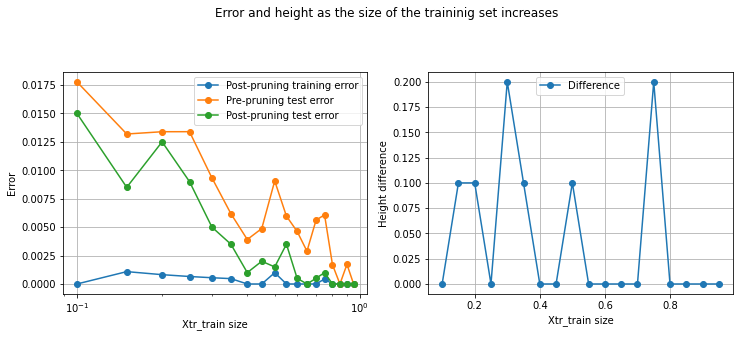

In [17]:
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 300) # training set
Xte, Yte = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # test set
step = 0.05
ripetitions = 10
p_list = np.arange(0.1, 0.99 , step) # percentages
print("Sizes: ", p_list)
# means 
err_post_pruning_train = np.zeros(p_list.size)
err_pre_pruning_test = np.zeros(p_list.size)
err_post_pruning_test = np.zeros(p_list.size)
height_pre_pruning_list = np.zeros(p_list.size) # height pre-pruning
height_post_pruning_list = np.zeros(p_list.size) # height post-pruning
height_difference = np.zeros(p_list.size) # difference between height pre-pruning and height post-pruning

for idx, p in enumerate(p_list):
    for i in range(ripetitions):
        
        # the training set increases
        Xtr_train, Ytr_train, Xtr_prun, Ytr_prun = splitData(Xtr, Ytr, p) # p data points go to pruning set
        Dt = DTC(float('+inf'), (Xtr_train, Ytr_train), attributes_list, DTC.GINI) 
        Dt.train()
        height_pre_pruning_list[idx] += Dt.getMaxDepth()
        err_pre_pruning_test[idx] += Dt.test(Xtr_prun, Ytr_prun) [2]
        Dt.pruning(Xtr_prun, Ytr_prun)
        # calc error post pruning
        err_post_pruning_train[idx] += Dt.test(Xtr_train, Ytr_train) [2] 
        err_post_pruning_test[idx] += Dt.test(Xte, Yte) [2]
        height_post_pruning_list[idx] += Dt.getMaxDepth()
        
    # means are calculated
    err_post_pruning_train[idx] /= ripetitions
    err_pre_pruning_test[idx] /= ripetitions
    err_post_pruning_test[idx] /= ripetitions
    height_pre_pruning_list[idx] /= ripetitions
    height_post_pruning_list[idx] /= ripetitions
    height_difference[idx] = height_pre_pruning_list[idx] - height_post_pruning_list[idx]
    
fig = plt.figure(figsize=(12,9))
plt.suptitle("Error and height as the size of the traininig set increases")
ax0 = fig.add_subplot(2, 2, 1)
ax0.semilogx(p_list, err_post_pruning_train, '-o', label= 'Post-pruning training error')
ax0.semilogx(p_list, err_pre_pruning_test, '-o', label= 'Pre-pruning test error')
ax0.semilogx(p_list, err_post_pruning_test, '-o', label= 'Post-pruning test error')
ax0.set_xlabel('Xtr_train size')
ax0.set_ylabel('Error')
ax0.axis("tight")
ax0.legend()
ax0.grid()
ax1 = fig.add_subplot(2, 2, 2)
ax1.plot(p_list, height_difference, '-o', label= 'Difference')
ax1.set_xlabel('Xtr_train size')
ax1.set_ylabel('Height difference')
ax1.axis("tight")
ax1.legend()
ax1.grid()
plt.show()

From these plots, we observe that:
* With the increase of the size of *Xtr_train*, the post-pruning training error tends to remain the same and almost equal to zero.
* With the increase of the size of *Xtr_train*, the gap between the pre-pruning test error and the post-pruning test error is incrementally reduced and they both decrease down to a value almost equal to zero. So, incrementing the size of *Xtr_train* reduces overfitting also without pruning. To see a more evident result, it would be better to use a larger dataset.
* With the increase of the size of *Xtr_train*, the difference between height pre-pruning and height post-pruning seems to be very unstable and the pruning is not so evident probably because, as said before, the dataset is not enough large.

### Finding the Best Height

Since the height is a very influent parameter, we want to find the best height using the k-fold cross-validation procedure.

Heights:  [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
Best height:  3
Test error:  0.01


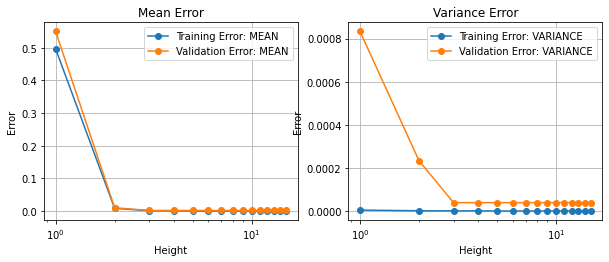

In [18]:
classes = [-1,1] # label classes
attributes_list = [[0], [1]] # indexes of the columns to be considered by the algorithm
Xtr, Ytr = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 300) # training set
Xte, Yte = mixGauss([[0,0], [2.3,1.8]], [0.5, 0.5], 100) # test set
height_list = np.arange(1, 16)
print("Heights: ", height_list)
KF = 15

best_height_list, Vm, Vs, Tm, Ts = bestHeight_KFoldCV(Xtr, Ytr, attributes_list, classes, DTC.GINI, KF, height_list) 
best_height = best_height_list[0]
print("Best height: ", best_height)

Dt = DTC(best_height, (Xtr,Ytr), attributes_list, DTC.GINI) 
Dt.train()

err = Dt.test(Xte, Yte) [2]
print("Test error: ", err)

plotErrorBestDepthMethod(Vm, Vs, Tm, Ts, height_list)

The best height is equal to 3, so this problem should be non-linearly separable.